# DAG_JdCov

This manual is to show how to preform causal discovery(DAG) and causal inference(JdCov)

## package

In [1]:
## packages
library(dHSIC)           # dHSIC
library(mgcv)            # gam
library(graph)           
library(energy)          # dCov
library(pcalg)           # pc algorithm for DAG

## clear 
rm(list = ls())
graphics.off()

## working directory
setwd('D:/Code/Econometrics/DAG/working/Rcodes_JdCov/Rcodes')
## load some functions
source('./JdCov.R')

Warning message:
"package 'dHSIC' was built under R version 3.6.3"
Loading required package: nlme

This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
   

## Data

In [2]:
df <- read.csv('./KAM2018.csv')

rn <- names(df)
n <- nrow(df)
d <- ncol(df)

## DAG

Using PC algorithm and its stable version to figure out candidate DAGs 

**Note:** The DAGs model are saved as matrics and (i,j) = 1 means i is a cause of j, j is a effect of i, that is i --> j.

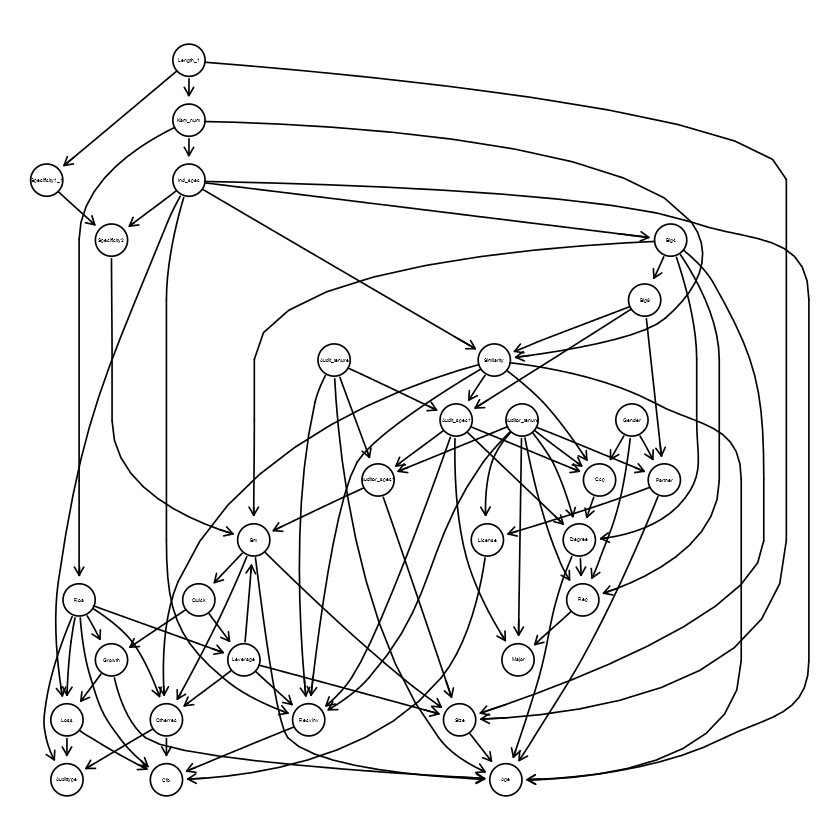

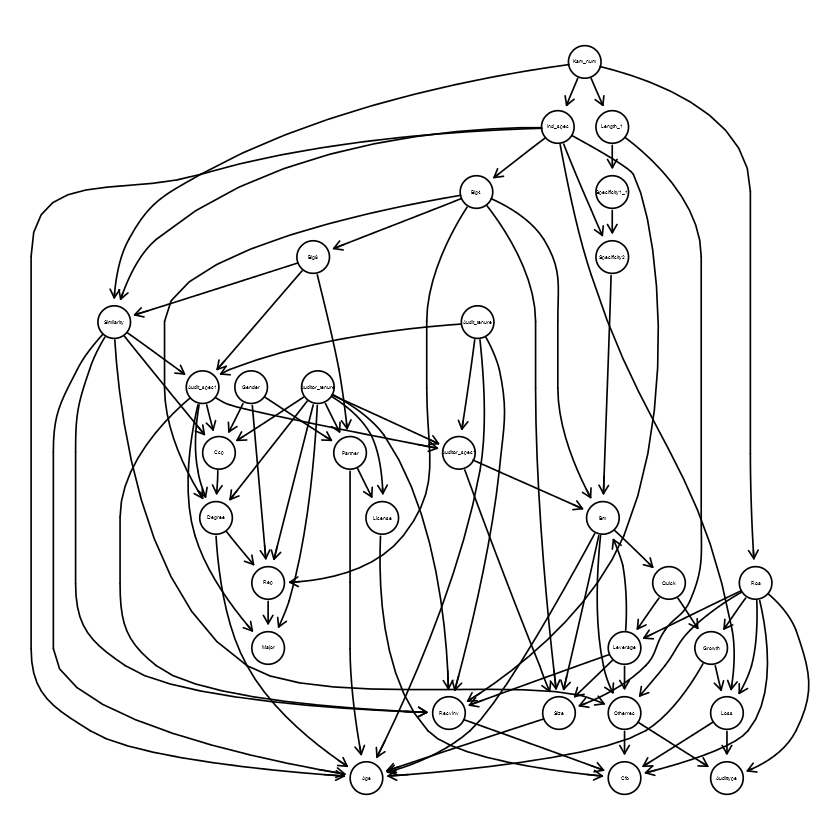

In [3]:
df.cor <- cor(df)

## PC
df.fit <- pc(suffStat = list(C = df.cor, n = n),
            indepTest = gaussCItest, 
            alpha=0.1, labels = rn, verbose = FALSE)
df.mat <- t(matrix(as.numeric(as(df.fit, "amat")), nrow = d))

## undirected
mat.bd <- df.mat==1 & t(df.mat)==1  ## bidirected edges matrix
df.mat[mat.bd] <- 0
mat.bd[upper.tri(mat.bd)] <- FALSE  ## only leave lower part
ind.bd <- which(mat.bd == TRUE)  ## bidirected edges index (lower matrix index)

allDags <- list()
for(i in 1:length(ind.bd)) {
  tmp <- combn(1:length(ind.bd), i)
  ind <- matrix(0, nrow=nrow(mat.bd), ncol=ncol(mat.bd))
  x <- ind.bd[tmp]
  ind[x] <- 1

  allDags <- cbind(allDags, list(as.numeric(df.mat + ind)), list(as.numeric(df.mat + t(ind))))
}

## PC stable
df.fit <- pc(suffStat = list(C = df.cor, n = n),
             indepTest = gaussCItest, skel.method = 'stable',
             alpha=0.1, labels = rn, verbose = FALSE)
df.mat <- t(matrix(as.numeric(as(df.fit, "amat")), nrow = d))

## undirected
mat.bd <- df.mat==1 & t(df.mat)==1  ## bidirected edges matrix
df.mat[mat.bd] <- 0
mat.bd[upper.tri(mat.bd)] <- FALSE  ## only leave lower part
ind.bd <- which(mat.bd == TRUE)  ## bidirected edges index (lower matrix index)

for(i in 1:length(ind.bd)) {
  tmp <- combn(1:length(ind.bd), i)
  ind <- matrix(0, nrow=nrow(mat.bd), ncol=ncol(mat.bd))
  x <- ind.bd[tmp]
  ind[x] <- 1
  
  allDags <- cbind(allDags, list(as.numeric(df.mat + ind)), list(as.numeric(df.mat + t(ind))))
}

allDags <- lapply(allDags, 
                       function(x) matrix(x, d, d, dimnames = list(rn, rn)))
numDAGs <- length(allDags)

for(i in 1:numDAGs/2) {
  plot(graphAM(adjMat = allDags[[i]], edgemode="directed"))
}

## JdCov

Performing model selection in causal inference, which is based on the joint independence testing of the residuals from the fitted structural equation models.

In [ ]:
X <- lapply(df, as.matrix)
names(X) <- paste0('X', 1:d) 

## initialize parameter
B=100 ; cc=1

# initalize pvalue vector
pval_dhsic_p <- vector("numeric",numDAGs)
pval_Jdcov_p <- vector("numeric",numDAGs)
pval_JdcovUS_p <- vector("numeric",numDAGs)
pval_JdcovR_p <- vector("numeric",numDAGs)
pval_MS16_p <- vector("numeric",numDAGs)

# compute the p-value for each DAG model

for(i in 1:numDAGs){
  
  A <- allDags[[i]] 
  # initialize residual vector
  # res <- list()
  # res[[1]]=res[[2]]=res[[3]]=res[[4]]=res[[5]]=matrix(0,nrow=n,ncol=1)
  # fitgam <- list()
  # fitgam[[1]]=fitgam[[2]]=fitgam[[3]]=fitgam[[4]]=fitgam[[5]]=matrix(0,nrow=n,ncol=1)
  res <- rep(list(matrix(0, nrow=n, ncol=1)), d)
  fitgam <- rep(list(matrix(0, nrow=n, ncol=1)), d)
  
  # regress each node on its variables and collect the residuals
  for(j in 1:d){
    if(sum(A[,j])==0){
      res[[j]][,1] <- X[[j]]
    }
    else{
      formula <- paste("X",toString(j),"~",sep="")
      for(k in 1:d){
        if(A[k,j]==1){
          if((sum(A[,j])-sum(A[1:k,j]))==0){
            formula <- paste(formula,"X",toString(k),"",sep="")
          }
          else{
            formula <- paste(formula,"X",toString(k),"+",sep="")
          }
        }
      }
      #print(formula)
      # print(formula)
      g <- lm(as.formula(formula), data=X)
      res[[j]][,1] <- as.numeric(g$residuals)
      fitgam[[j]][,1] <- as.numeric(g$fitted.values)
    }
  }
  
  x=res
  ## computing values of the original statistics
  stat.dhsic <- dhsic(X=x,kernel="gaussian")$dHSIC
  stat <- Jdcov.sq.U.list(x,cc) 
  stat.s <- Jdcov.sq.US.list(x,cc)
  
  x.r <- x
  for(j in 1:d) {
    for(l in 1:ncol(x[[j]])){
      f.cdf <- ecdf(x[[j]][,l]); x.r[[j]][,l] <- f.cdf(x[[j]][,l])
    }
  }
  
  stat.r <- Jdcov.sq.U.list(x.r,cc)
  stat4 <- 0
  for(b in 1:(d-1)) stat4 <- stat4 + dcovU(x[[b]],do.call(cbind,x[(b+1):d]))^2
  
  ## creating storage spaces for bootstrap resamples
  stat.pdhsic <- stat.p <- stat.pr <- stat.ps  <- stat.p4 <- rep(0, B)
  
  
  for(ii in 1:B) {
    
    # res.B <- list() ; res.new <- list()
    # res.B[[1]]=res.B[[2]]=res.B[[3]]=res.B[[4]]=res.B[[5]]=matrix(0,nrow=n,ncol=1)
    # res.new[[1]]=res.new[[2]]=res.new[[3]]=res.new[[4]]=res.new[[5]]=matrix(0,nrow=n,ncol=1)
    res.B <- rep(list(matrix(0,nrow=n,ncol=1)), d)
    res.new <- rep(list(matrix(0,nrow=n,ncol=1)), d)
    Y.B = list()
    
    for(j in 1:d){
      res.B[[j]]=as.matrix(res[[j]][sample(1:n,n,replace=TRUE),])
      Y.B[[j]]=fitgam[[j]]+res.B[[j]]
    }
    # XB=list(XB1=Y.B[[1]],XB2=Y.B[[2]],XB3=Y.B[[3]],XB4=Y.B[[4]],XB5=Y.B[[5]])
    XB <- Y.B
    names(XB) <- paste0('XB', 1:d)
    for(j in 1:d){
      if(sum(A[,j])==0){
        res.new[[j]][,1] <- XB[[j]]
      }
      else{
        formula <- paste("XB",toString(j),"~",sep="")
        for(k in 1:d){
          if(A[k,j]==TRUE){
            if((sum(A[,j])-sum(A[1:k,j]))==0){
              formula <- paste(formula,"XB",toString(k),"",sep="")
            }
            else{
              formula <- paste(formula,"XB",toString(k),"+",sep="")
            }
          }
        }
        # print(formula)
        gB=lm(as.formula(formula),data=XB)
        res.new[[j]][,1] <- as.numeric(gB$residuals)
      }
    }
    
    x=res.new
    stat.pdhsic[ii] <- dhsic(X=x,kernel="gaussian")$dHSIC
    stat.p[ii] <- Jdcov.sq.U.list(x,cc) 
    stat.ps[ii] <- Jdcov.sq.US.list(x,cc)
    
    x.r <- x
    for(j in 1:d) {
      for(l in 1:ncol(x[[j]])){
        f.cdf <- ecdf(x[[j]][,l]); x.r[[j]][,l] <- f.cdf(x[[j]][,l])
      }
    }
    
    stat.pr[ii] <- Jdcov.sq.U.list(x.r,cc)
    stat.p4[ii] <- 0
    for(b in 1:(d-1)) stat.p4[ii] <- stat.p4[ii] + dcovU(x[[b]],do.call(cbind,x[(b+1):d]))^2
    
  }    
  
  pval_dhsic_p[i] = length(stat.pdhsic[stat.pdhsic > stat.dhsic]) /B 
  pval_Jdcov_p[i] = length(stat.p[stat.p > stat]) /B
  pval_JdcovUS_p[i] = length(stat.ps[stat.ps > stat.s]) /B
  pval_JdcovR_p[i] = length(stat.pr[stat.pr > stat.r]) /B
  pval_MS16_p[i] = length(stat.p4[stat.p4 > stat4]) /B
  
}

max.idx <- c(which.max(which.max(pval_dhsic_p)),
             which.max(pval_Jdcov_p),
             which.max(pval_JdcovUS_p),
             which.max(pval_JdcovR_p),
             which.max(pval_MS16_p))
cri.idx <- c('dHIC', 'JdCov', 'JdCovUS', 'JdCovR', 'MT')

for(i in 1:length(max.idx)) {
    print(cri.idx[i])
    print(allDags[[max.idx[i]]])
    
}
par(mfrow = c(3,2))
for(i in 1:length(max.idx)) {
    plot(graphAM(adjMat = allDags[[max.idx[i]]], edgemode="directed"), main = cri.idx[i])
}